# Comparision of methods for time delay estimation on semi-simulated event-based time-series data

**Methods:**
1. Nearest Advocate (NAd): dense, different sparse-factors  
1. Pearson Cross-correlation (PCC): FFT and DFT  
1. Kernel Cross-correlation (KCC)  
1. Dynamic Time Warping (DTW)  

**Experiments:**
1. Sample different lenghts  
1. Different noise
1. remove a fraction of the events  
1. Linear time-warping

In [1]:
import os
import time

import numpy as np
np.random.seed(0)
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from multiprocessing import Pool

# Load methods
%matplotlib inline

In [2]:
# importer for the methods, styles and data
from config import colorscheme
from methods import modify_timeseries, nearest_advocate, pearson_cc, kernel_cc, dynamic_linear_timewarping
from data_loader import load_heart_beats, load_breath_rate, load_step_rate

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
# directories to load
PATH_HEART_RATE_DATA = "../data/HeartBeatData"
PATH_BREATH_RATE_DATA = "../data/BreathRateData"
PATH_STEP_RATE_DATA = "../data/StepRateData"

# parameters to semi-simulate data
SIGMA = 0.1

# parameters for Nearest-Advocate
DIST_MAX = -1           # use the default values for dist_max and dist_padding of nearest_advocate
REGULATE_PADDINGS = True  # regulate the paddings in nearest_advocate
TD_MAX = 300               # search space of 10 minutes
TD_MIN = -300
SAMPLES_PER_S = 10        # precision of the search space (for steps of mean freq 0.5s)

## Data

### Load the datasets

In [4]:
heart_beat_dataset = load_heart_beats(path_to_dir=PATH_HEART_RATE_DATA, verbose=1)

Loading files S18_11_nn.txt and S18_1_beats_synced.csv.
Loading files S18_21_nn.txt and S18_2_beats_synced.csv.
Loading files S19_11_nn.txt and S19_1_beats_synced.csv.
Loading files S20_11_nn.txt and S20_1_beats_synced.csv.
Loading files S20_21_nn.txt and S20_2_beats_synced.csv.
Loading files S21_11_nn.txt and S21_1_beats_synced.csv.
Loading files S21_21_nn.txt and S21_2_beats_synced.csv.
Loading files S23_11_nn.txt and S23_1_beats_synced.csv.
Loading files S23_21_nn.txt and S23_2_beats_synced.csv.
Loading files S24_11_nn.txt and S24_1_beats_synced.csv.
Loading files S24_21_nn.txt and S24_2_beats_synced.csv.
Loading files S26_11_nn.txt and S26_1_beats_synced.csv.
Loading files S27_11_nn.txt and S27_1_beats_synced.csv.
Loading files S28_11_nn.txt and S28_1_beats_synced.csv.
Loading files S28_21_nn.txt and S28_2_beats_synced.csv.
Loading files S29_11_nn.txt and S29_1_beats_synced.csv.
Loading files S29_21_nn.txt and S29_2_beats_synced.csv.


In [5]:
breath_rate_dataset = load_breath_rate(path_to_dir=PATH_BREATH_RATE_DATA, verbose=1)

Loading files P05_Reference_FlowReversals_OVERALL.csv and P05_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P06_Reference_FlowReversals_OVERALL.csv and P06_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P07_Reference_FlowReversals_OVERALL.csv and P07_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P08_Reference_FlowReversals_OVERALL.csv and P08_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P09_Reference_FlowReversals_OVERALL.csv and P09_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P10_Reference_FlowReversals_OVERALL.csv and P10_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P11_Reference_FlowReversals_OVERALL.csv and P11_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P12_Reference_FlowReversals_OVERALL.csv and P12_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P13_Reference_FlowReversals_OVERALL.csv and P13_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P14_Reference_FlowReversals_OVERALL.csv and P14_SportsSRS_FlowReversals_OVERALL.csv.
Loading fi

In [6]:
step_rate_dataset = load_step_rate(path_to_dir=PATH_STEP_RATE_DATA, verbose=1)

Loading files P04_Reference_Strides_OVERALL.csv and P04_SportsSRS_Strides_OVERALL.csv.
Loading files P06_Reference_Strides_OVERALL.csv and P06_SportsSRS_Strides_OVERALL.csv.
Loading files P07_Reference_Strides_OVERALL.csv and P07_SportsSRS_Strides_OVERALL.csv.
Loading files P08_Reference_Strides_OVERALL.csv and P08_SportsSRS_Strides_OVERALL.csv.
Loading files P09_Reference_Strides_OVERALL.csv and P09_SportsSRS_Strides_OVERALL.csv.
Loading files P10_Reference_Strides_OVERALL.csv and P10_SportsSRS_Strides_OVERALL.csv.
Loading files P11_Reference_Strides_OVERALL.csv and P11_SportsSRS_Strides_OVERALL.csv.
Loading files P12_Reference_Strides_OVERALL.csv and P12_SportsSRS_Strides_OVERALL.csv.
Loading files P13_Reference_Strides_OVERALL.csv and P13_SportsSRS_Strides_OVERALL.csv.
Loading files P16_Reference_Strides_OVERALL.csv and P16_SportsSRS_Strides_OVERALL.csv.
Loading files P18_Reference_Strides_OVERALL.csv and P18_SportsSRS_Strides_OVERALL.csv.
Loading files P19_Reference_Strides_OVERALL

## Function to semi-simulate the data

In [7]:
modify_timeseries(arr=heart_beat_dataset[0][0], offset=np.pi, subselect_length=10, sigma=0.1, fraction=0.5, 
                  time_warp_scale=0.005)

array([1985.2642013 , 1985.94322342, 1987.22308435, 1988.86971251,
       1990.34830416])

In [8]:
#  DTW yields more robust results for time-series shorter than 500 events using a higher overlap (/4)
def get_offset(length):
    l_bound, u_bound = max(TD_MIN, -length/2), min(TD_MAX, length/2)
    return np.random.random() * (u_bound-l_bound) + l_bound

def get_offset_array(array):
    l_bound = max(TD_MIN, -len(array)/2, -SUBSELECT_LENGTH/2)
    u_bound = min(TD_MAX, len(array)/2, SUBSELECT_LENGTH/2)
    return np.random.random() * (u_bound-l_bound) + l_bound

## Define Methods

In [9]:
# # Colorscheme for all methods
# custom_blues = sns.color_palette("Blues", 5)
# custom_reds = sns.color_palette("OrRd", 4)
# custom_greens = sns.color_palette("Greens", 4)
# custom_purp = sns.color_palette("BuPu", 4)

### Nearest Advocate

Found optimum for a time shift of 31.420s in 2.004s


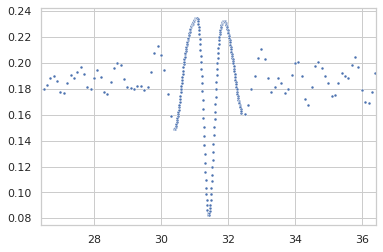

In [10]:
# run once before the test to just-in-time compile it
start_time = time.time()
arr_ref = np.cumsum(np.random.normal(loc=1, scale=0.25, size=1000))
arr_sig = modify_timeseries(arr=arr_ref, offset=10*np.pi, sigma=0.1, fraction=0.99,
                           time_warp_scale=0.00, subselect_length=100)
time_delays = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig, 
                             td_min=-100, td_max=100, td_prox=1, sps=SAMPLES_PER_S, sparse_factor=1, 
                             dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
print(f"Found optimum for a time shift of {time_shift:.3f}s in {time.time()-start_time:.3f}s")

sns.scatterplot(x=time_delays[:,0], y=time_delays[:,1], marker='.')
plt.xlim(time_shift-5.0, time_shift+5.0)
plt.show()

### Cross-Correlation

Found optimum at 31.400s with value 0.4921


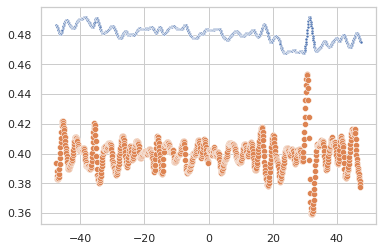

In [11]:

    
arr_ref = np.cumsum(np.random.normal(loc=1, scale=0.25, size=1000))
arr_sig = modify_timeseries(arr=arr_ref, offset=10*np.pi, sigma=0.1, fraction=0.99,
                           time_warp_scale=0.00, subselect_length=100)
time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, mode="same", method="fft")
# time_shift, metric = time_delays[np.argmax(time_delays[:,1])]
print(f"Found optimum at {time_shift:.3f}s with value {metric:.4f}")

sns.scatterplot(x=time_delays[:,0], y=time_delays[:,1], marker='.')
sns.scatterplot(x=time_delays[:-1,0], y=0.4+25*np.diff(time_delays[:,1]))
plt.show()

### Kernel Cross-Correlation

Found optimum at 31.400s with value 48.5000


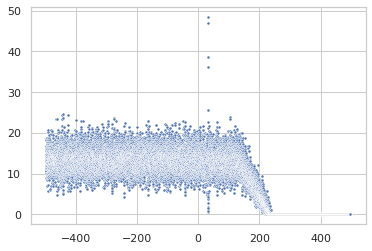

In [12]:
arr_ref = np.cumsum(np.random.normal(loc=1, scale=0.25, size=1000))
arr_sig = modify_timeseries(arr=arr_ref, offset=10*np.pi, sigma=0.1, fraction=0.99,
                           time_warp_scale=0.00, subselect_length=100)
time_shift, metric, time_delays = kernel_cc(arr_ref, arr_sig, mode="same", method="fft", kernel_width=0.2)
print(f"Found optimum at {time_shift:.3f}s with value {metric:.4f}")

sns.scatterplot(x=time_delays[:,0], y=time_delays[:,1], marker='.')
plt.show()

### Dynamic Linear Timewarping

Found resulting median shift of 31.500s in 0.0080276s


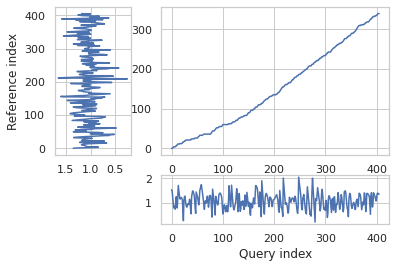

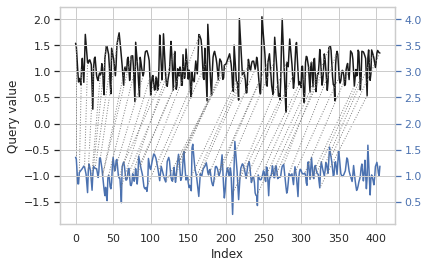

In [13]:
start_time = time.time()
arr_ref = np.cumsum(np.random.normal(loc=1, scale=0.25, size=1000))
arr_sig = modify_timeseries(arr=arr_ref, offset=10*np.pi, sigma=0.2, fraction=0.99,
                           time_warp_scale=0.00, subselect_length=200)

#distance, warped_path, element_shift, median_element_shift, time_shift, median_time_shift = dynamic_linear_timewarping(arr_ref, arr_sig)
time_shift, alignment = dynamic_linear_timewarping(arr_ref, arr_sig)
print(f"Found resulting median shift of {time_shift:.3f}s in {time.time()-start_time:.5g}s")

# Plot with the Rabiner-Juang type VI-c unsmoothed recursion
alignment.plot(type="threeway") 
alignment.plot(type="twoway",offset=-2)
plt.show()

## Experiment 1.1: Precision by Length on simulated data

The time-series is purely simulated, as the longest real arrays are about 30,000 events long

In [14]:
LENGTHS = [int(l) for l in [1e1, 2e1, 5e1, 1e2, 2e2, 5e2, 1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 1e6]] # TODO all
N_ITERATIONS = 25         # number of iterations per length, used for the interquartils
METHODS = ['NAd-dense', 'NAd-sparse10', 'NAd-sparse100', 'PCC-FFT', 'PCC-DFT', 'KCC-1', 'KCC-0.5', 'DTW-asym'] 
# don't use PCC-DFT here as it uses multiple cores by default

REF_SIGMA = 0.5
SIGMA = 0.25

MAX_TIMEOUT = 3  # maximal wait time to ignore the method afterwards
ignore_method_timeout = {k: False for k in METHODS}

In [15]:
# evaluate a given length
def evaluate_length(iteration):
    # define the local DataFrame for one single pair
    df_precision = pd.DataFrame({m: np.nan*np.zeros(len(LENGTHS)) for m in METHODS})
    df_precision["length"] = LENGTHS

    for idx, length in enumerate(LENGTHS):
        np.random.seed(N_ITERATIONS*iteration+idx)
        offset = get_offset(length)
        # Create two related event-based array, they differ by a time-shift and gaussian noise
        arr_ref = np.sort(np.cumsum(np.random.normal(loc=1, scale=REF_SIGMA, size=int(length)))).astype(np.float32)
        arr_sig = np.sort(arr_ref + offset + np.random.normal(loc=0, scale=SIGMA, size=int(length))).astype(np.float32)

        # NAd-dense
        if not ignore_method_timeout["NAd-dense"]:
            start_time = time.time()
            time_delays = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
            df_precision.loc[idx, "NAd-dense"] = np.abs(time_shift-offset)
            if time.time() - start_time > MAX_TIMEOUT:
                ignore_method_timeout["NAd-dense"] = True

        # NAd-sparse10
        if not ignore_method_timeout["NAd-sparse10"]:
            try:
                start_time = time.time()
                time_delays = nearest_advocate(
                    arr_ref=arr_ref, arr_sig=arr_sig, 
                    td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=10, 
                    dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
                time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
                df_precision.loc[idx, "NAd-sparse10"] = np.abs(time_shift-offset)
                if time.time() - start_time > MAX_TIMEOUT:
                    ignore_method_timeout["NAd-sparse10"] = True
            except AssertionError:
                pass

        # NAd-sparse100
        if not ignore_method_timeout["NAd-sparse100"]:
            start_time = time.time()
            try:
                time_delays = nearest_advocate(
                    arr_ref=arr_ref, arr_sig=arr_sig, 
                    td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=100, 
                    dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
                time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
                df_precision.loc[idx, "NAd-sparse100"] = np.abs(time_shift-offset)
                if time.time() - start_time > MAX_TIMEOUT:
                    ignore_method_timeout["NAd-sparse100"] = True
            except AssertionError:
                pass
                # print(f"WARNING: AssertionError, skipping.")

        # PCC-FFT
        if not ignore_method_timeout["PCC-FFT"]:
            start_time = time.time()
            time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, method="fft")
            df_precision.loc[idx, "PCC-FFT"] = np.abs(time_shift-offset)
            if time.time() - start_time > MAX_TIMEOUT:
                ignore_method_timeout["PCC-FFT"] = True
        
        # # PCC-FFT
        # start_time = time.time()
        # time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, method="fft", smooth_outliers=True)
        # df_precision.loc[idx, "PCC-FFT-smooth"] = np.abs(time_shift-offset)
                
        # PCC-DFT
        if not ignore_method_timeout["PCC-DFT"]:
            start_time = time.time()
            time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, method="direct")
            df_precision.loc[idx, "PCC-DFT"] = np.abs(time_shift-offset) # the same
            if time.time() - start_time > MAX_TIMEOUT:
                ignore_method_timeout["PCC-DFT"] = True
                
        # KCC
        if not ignore_method_timeout["KCC-1"]:
            start_time = time.time()
            try:
                time_shift, metric, time_delays = kernel_cc(arr_ref, arr_sig, method="fft", kernel_width=1.0)
                df_precision.loc[idx, "KCC-1"] = np.abs(time_shift-offset)
                # print(f"\n{time_shift:.3f},\t {offset:.3f}", end="")
                if time.time() - start_time > MAX_TIMEOUT:
                    ignore_method_timeout["KCC-1"] = True
            except:
                pass
        # KCC-0.5
        if not ignore_method_timeout["KCC-0.5"]:
            try:
                time_shift, metric, time_delays =  kernel_cc(arr_ref, arr_sig, method="fft", kernel_width=0.5)
                df_precision.loc[idx, "KCC-0.5"] = np.abs(time_shift-offset)
                if time.time() - start_time > MAX_TIMEOUT:
                    ignore_method_timeout["KCC-0.5"] = True
            except AssertionError:
                pass
        
        # DTW-asym
        if not ignore_method_timeout["DTW-asym"]:
            start_time = time.time()
            time_shift, alignment = dynamic_linear_timewarping(arr_ref, arr_sig)
            df_precision.loc[idx, "DTW-asym"] = np.abs(time_shift-offset)
            if time.time() - start_time > MAX_TIMEOUT:
                ignore_method_timeout["DTW-asym"] = True
    
    return df_precision

# Initialize the pool with the number of processes
with Pool(processes=30) as pool: 
    results = pool.map(evaluate_length, range(N_ITERATIONS))
#df_runtimes = pd.concat([res[0] for res in results]).sort_values("length")
df_precision = pd.concat(results).sort_values("length")
df_precision.sample(5)

,NAd-dense,NAd-sparse10,NAd-sparse100,PCC-FFT,PCC-DFT,KCC-1,KCC-0.5,DTW-asym,length
2,0.031686,1.181686,NaN,0.110309,0.110309,0.010309,0.039691,15.289691,50
9,0.005460,0.005460,0.014545,0.070294,NaN,0.020294,0.020294,NaN,10000
7,0.007690,0.022309,318.197689,0.015026,0.015026,0.015026,0.015026,0.215026,2000
14,NaN,NaN,0.029221,0.029224,NaN,0.020776,NaN,NaN,500000
7,0.003655,0.058937,0.071052,0.003658,0.003658,0.003658,0.003658,0.196342,2000


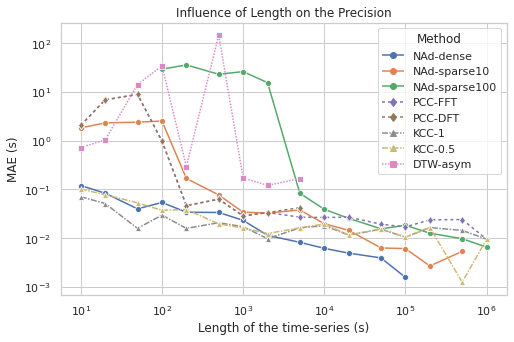

In [16]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_precision_melted = pd.melt(df_precision, id_vars="length", var_name="Method", 
                              value_vars=METHODS, value_name="precision")

precision_plot = sns.lineplot(data=df_precision_melted, 
                              x="length", y="precision", 
                              hue="Method", style="Method", 
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS}, 
                              estimator=np.median, errorbar=None)  # lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))
plt.title("Influence of Length on the Precision")
plt.xlabel("Length of the time-series (s)")
plt.ylabel("MAE (s)")
# plt.ylim((0.02, 50))
precision_plot.set(xscale='log')
precision_plot.set(yscale='log')
plt.savefig("fig/semisimulated_precision_length.png")
plt.show()

## Experiment 1.b: Runtime by Length on simulated data

The time-series is purely simulated, as the longest real arrays are about 30,000 events long

In [17]:
N_ITERATIONS = 3         # number of iterations per length, used for the interquartils
METHODS = ['NAd-dense', 'NAd-sparse10', 'NAd-sparse100', 'PCC-FFT', 'PCC-DFT', 'KCC-1', 'KCC-0.5', 'DTW-asym']  

MAX_TIMEOUT = 3  # maximal wait time to ignore the method afterwards
ignore_method_timeout = {k: False for k in METHODS}

In [18]:
# evaluate a given length
def evaluate_length(iteration):
    # define the local DataFrame for one single pair
    df_runtimes = pd.DataFrame({m: np.nan*np.zeros(len(LENGTHS)) for m in METHODS})
    df_runtimes["length"] = LENGTHS

    # dummy evaluation for JIT-compiliation
    _ = nearest_advocate(
               arr_ref=np.array([1.0, 2.0, 3.0]).astype(np.float32), arr_sig=np.array([1.0, 2.0, 3.0]).astype(np.float32), 
                td_min=-1, td_max=+1, sps=SAMPLES_PER_S, sparse_factor=1, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
    
    for idx, length in enumerate(LENGTHS):
        np.random.seed(N_ITERATIONS*iteration+idx)        
        offset = get_offset(length)
        # Create two related event-based array, they differ by a time-shift and gaussian noise
        arr_ref = np.sort(np.cumsum(np.random.normal(loc=1, scale=REF_SIGMA, size=int(length)))).astype(np.float32)
        arr_sig = np.sort(arr_ref + offset + np.random.normal(loc=0, scale=SIGMA, size=int(length))).astype(np.float32)

        # NAd-dense
        if not ignore_method_timeout["NAd-dense"]:
            start_time = time.time()
            time_delays = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
            df_runtimes.loc[idx, "NAd-dense"] = time.time() - start_time
            if time.time() - start_time > MAX_TIMEOUT:
                ignore_method_timeout["NAd-dense"] = True

        # NAd-sparse10
        if not ignore_method_timeout["NAd-sparse10"]:
            start_time = time.time()
            time_delays = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=10, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
            df_runtimes.loc[idx, "NAd-sparse10"] = time.time() - start_time
            if time.time() - start_time > MAX_TIMEOUT:
                ignore_method_timeout["NAd-sparse10"] = True

        # NAd-sparse100
        if not ignore_method_timeout["NAd-sparse100"]:
            start_time = time.time()
            try:
                time_delays = nearest_advocate(
                    arr_ref=arr_ref, arr_sig=arr_sig, 
                    td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=100, 
                    dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
                time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
                df_runtimes.loc[idx, "NAd-sparse100"] = time.time() - start_time
                if time.time() - start_time > MAX_TIMEOUT:
                    ignore_method_timeout["NAd-sparse100"] = True
            except AssertionError:
                pass
                # print(f"WARNING: AssertionError, skipping.")
        
        # PCC-FFT
        if not ignore_method_timeout["PCC-FFT"]:
            start_time = time.time()
            time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, method="fft")
            df_runtimes.loc[idx, "PCC-FFT"] = time.time() - start_time
            if time.time() - start_time > MAX_TIMEOUT:
                ignore_method_timeout["PCC-FFT"] = True
        
        # PCC-DFT: only for runtimes
        if not ignore_method_timeout["PCC-DFT"]:
            start_time = time.time()
            time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, method="direct")
            df_runtimes.loc[idx, "PCC-DFT"] = time.time() - start_time
            # df_precision.loc[idx, "PCC-DFT"] = np.abs(time_shift-offset) # the same
            if time.time() - start_time > MAX_TIMEOUT:
                ignore_method_timeout["PCC-DFT"] = True
        
        # KCC
        if not ignore_method_timeout["KCC-1"]:
            start_time = time.time()
            try:
                time_shift, metric, time_delays = kernel_cc(arr_ref, arr_sig, method="fft", kernel_width=1.0)
                df_runtimes.loc[idx, "KCC-1"] = time.time() - start_time
                if time.time() - start_time > MAX_TIMEOUT:
                    ignore_method_timeout["KCC-1"] = True
            except:
                pass
        # KCC-0.5
        if not ignore_method_timeout["KCC-0.5"]:
            try:
                start_time = time.time()
                time_shift, metric, time_delays =  kernel_cc(arr_ref, arr_sig, method="fft", kernel_width=0.5)
                df_runtimes.loc[idx, "KCC-0.5"] = time.time() - start_time
                if time.time() - start_time > MAX_TIMEOUT:
                    ignore_method_timeout["KCC-0.5"] = True
            except AssertionError:
                pass
        
        # DTW-asym
        if not ignore_method_timeout["DTW-asym"]:
            start_time = time.time()
            time_shift, alignment = dynamic_linear_timewarping(arr_ref, arr_sig)
            df_runtimes.loc[idx, "DTW-asym"] = time.time() - start_time
            if time.time() - start_time > MAX_TIMEOUT:
                ignore_method_timeout["DTW-asym"] = True
    
    return df_runtimes
    
# Don't run in parallel, as PCC-DFT claims all available cores
results = list()
for it in range(N_ITERATIONS):
    results.append(evaluate_length(it))
    print(f"Part {it+1} completed")
df_runtimes = pd.concat(results).sort_values("length")
# df_precision = pd.concat([res[1] for res in results]).sort_values("length")

Part 1 completed
Part 2 completed
Part 3 completed


In [19]:
df_runtimes.sample(5)

,NAd-dense,NAd-sparse10,NAd-sparse100,PCC-FFT,PCC-DFT,KCC-1,KCC-0.5,DTW-asym,length
1,NaN,NaN,NaN,NaN,NaN,NaN,0.000178,NaN,20
3,NaN,NaN,NaN,NaN,NaN,NaN,0.000251,NaN,100
6,0.035191,0.006769,0.004294,0.001019,0.014554,0.001757,0.001095,0.076143,1000
5,0.015386,0.002661,0.001344,0.000626,0.002902,0.001059,0.000586,0.020935,500
5,NaN,NaN,NaN,NaN,NaN,NaN,0.000696,NaN,500


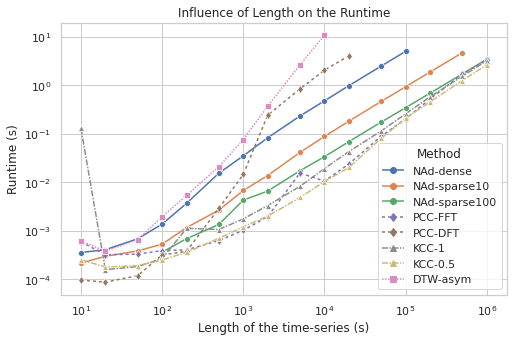

In [20]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_runtimes_melted = pd.melt(df_runtimes, id_vars="length", var_name="Method", 
                              value_vars=METHODS, value_name="runtime")
runtime_plot = sns.lineplot(data=df_runtimes_melted, 
                              x="length", y="runtime", 
                              hue="Method", style="Method", 
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS}, 
                              estimator=np.median, errorbar=None)  # lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))
plt.title("Influence of Length on the Runtime")
plt.xlabel("Length of the time-series (s)")
plt.ylabel("Runtime (s)")
runtime_plot.set(xscale='log')
runtime_plot.set(yscale='log')
plt.savefig("fig/semisimulated_runtime_length.png")
plt.show()

### Plot both charts at once

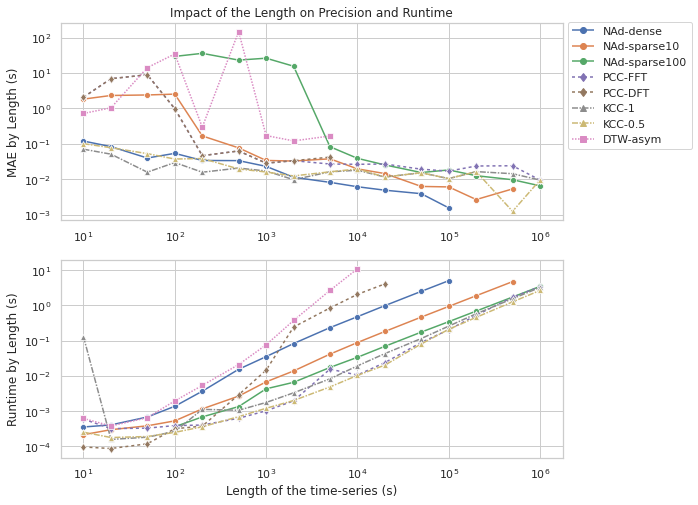

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(9,8))
axes[0].set_title("Impact of the Length on Precision and Runtime")

# Precision Plot
precision_plot = sns.lineplot(data=df_precision_melted, 
                              x="length", y="precision", 
                              hue="Method", style="Method", 
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS}, 
                              estimator=np.median, errorbar=None,
                              ax=axes[0])
axes[0].set_xlabel("")  # "Length of the time-series (s)"
axes[0].set_ylabel("MAE by Length (s)")
precision_plot.set(xscale='log')
precision_plot.set(yscale='log')

# Runtime Plot
runtime_plot = sns.lineplot(data=df_runtimes_melted, 
                              x="length", y="runtime", 
                              hue="Method", style="Method", 
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS}, 
                              estimator=np.median, errorbar=None,
                              ax=axes[1])  # lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))
axes[1].set_xlabel("Length of the time-series (s)")
axes[1].set_ylabel("Runtime by Length (s)")
runtime_plot.set(xscale='log')
runtime_plot.set(yscale='log')

axes[0].legend(loc=(1.01, 0.36))
axes[1].get_legend().remove()
plt.savefig("fig/simulated_precision_and_runtime_by_length.png")
# TODO manually save the figure

## Experiment 2.a: Robustness by different noise on Semi-Simulated data

Fixate other settings

In [22]:
SIGMAS = [0, 0.01, 0.02, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
METHODS = ['NAd-dense', 'NAd-sparse10', 'NAd-sparse100', 'PCC-FFT', 'PCC-FFT-smooth', 'KCC-0.5', 'KCC-1', 'DTW-asym']  

# OFFSET = np.pi  # this is randomly sampled now
SUBSELECT_LENGTH = 1000
FRACTION = 1.0
TIME_WARP_SCALE = 0.0

In [23]:
# evaluate a given sigma
def evaluate_sigma(sigma):
    # generate semi-simulated pairs of measurements
    measurements = (heart_beat_dataset + breath_rate_dataset + step_rate_dataset)
    # measurements = (breath_rate_dataset)
    semi_simulated_pairs = list()
    n_measurements = 0
    for measurement in measurements:
        for array in measurement:
            l_bound = max(TD_MIN, -len(array)/2, -SUBSELECT_LENGTH/2)
            u_bound = min(TD_MAX, len(array)/2, SUBSELECT_LENGTH/2)
            offset = np.random.random() * (u_bound-l_bound) + l_bound
            semi_simulated_pairs.append(
                (array, modify_timeseries(arr=array, offset=offset, subselect_length=SUBSELECT_LENGTH, 
                                          sigma=sigma, fraction=FRACTION, time_warp_scale=TIME_WARP_SCALE),
                offset)
            )
            n_measurements += 1
    assert n_measurements == 2 * len(measurements)  # otherwise there ar !=2 arrays per measurement
    
    # define the local DataFrame for one single pair
    df_precision = pd.DataFrame({m: np.nan*np.zeros(n_measurements) for m in METHODS})
    df_precision["sigma"] = [sigma for _ in range(n_measurements)]

    # loop through all semi-simulated pairs
    for idx, (arr_ref, arr_sig, offset) in enumerate(semi_simulated_pairs):
        # NAd-dense
        time_delays = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
            dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
        df_precision.loc[idx, "NAd-dense"] = np.abs(time_shift-offset)

        # NAd-sparse10
        time_delays = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig, 
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=10, 
            dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
        time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
        df_precision.loc[idx, "NAd-sparse10"] = np.abs(time_shift-offset)

        # NAd-sparse100
        try:
            time_delays = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=100, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
            df_precision.loc[idx, "NAd-sparse100"] = np.abs(time_shift-offset)
        except AssertionError:
            pass
            # print(f"WARNING: AssertionError, skipping.")
        
        # PCC-FFT
        try:
            time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, method="fft")
            df_precision.loc[idx, "PCC-FFT"] = np.abs(time_shift-offset)
        except AssertionError:
            pass
        
        # PCC-FFT-smooth
        try:
            time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, method="fft", smooth_outliers=True)
            df_precision.loc[idx, "PCC-FFT-smooth"] = np.abs(time_shift-offset)
        except AssertionError:
            pass
        
        # KCC-0.5
        try:
            time_shift, metric, time_delays =  kernel_cc(arr_ref, arr_sig, method="fft", kernel_width=0.5)
            df_precision.loc[idx, "KCC-0.5"] = np.abs(time_shift-offset)
        except AssertionError:
            pass
        # KCC-1
        try:
            time_shift, metric, time_delays =  kernel_cc(arr_ref, arr_sig, method="fft", kernel_width=1.0)
            df_precision.loc[idx, "KCC-1"] = np.abs(time_shift-offset)
        except AssertionError:
            pass

        # DTW-asym
        try:
            time_shift, alignment = dynamic_linear_timewarping(arr_ref, arr_sig)
            df_precision.loc[idx, "DTW-asym"] = np.abs(time_shift-offset)
        except AssertionError:
            pass
    
    return df_precision
    
# Initialize the pool with the number of processes
with Pool(processes=30) as pool: 
    results = pool.map(evaluate_sigma, SIGMAS)
df_precision_noise = pd.concat(results).sort_values("sigma")
df_precision_noise.sample(5)

,NAd-dense,NAd-sparse10,NAd-sparse100,PCC-FFT,PCC-FFT-smooth,KCC-0.5,KCC-1,DTW-asym,sigma
78,0.004086,0.015919,187.574084,369.690334,0.009666,0.009666,0.059666,359.690334,0.40
24,0.000318,0.010318,0.013682,411.413682,411.413682,0.013682,10397.136318,0.086318,0.05
23,0.003739,0.003739,0.026264,0.008685,0.008685,0.008685,0.008685,0.191315,0.05
40,0.029276,14.320731,460.110754,0.020743,0.020743,0.029257,869.220743,0.020743,0.45
75,412.118408,311.048400,229.948394,0.056223,0.056223,1250.743777,1171.743777,27.543777,0.35


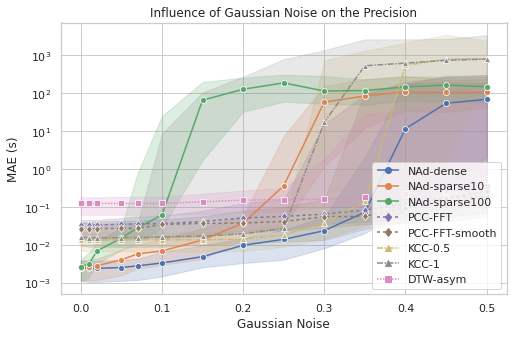

In [24]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_precision_noise_melted = pd.melt(df_precision_noise, id_vars="sigma", var_name="Method", 
                              value_vars=METHODS, value_name="precision")
precision_noise_plot = sns.lineplot(data=df_precision_noise_melted, 
                              x="sigma", y="precision", 
                              hue="Method", style="Method", 
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS}, 
                              estimator=np.median, errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))
plt.title("Influence of Gaussian Noise on the Precision")
plt.xlabel("Gaussian Noise")
plt.ylabel("MAE (s)")
# plt.ylim((0.02, 50))
precision_noise_plot.set(yscale='log')
# precision_plot.set(xscale='log')
plt.savefig("fig/semisimulated_precision_noise.png")
plt.legend(loc="lower right")
plt.show()

## Experiment 2.b: Robustness against missing events on Semi-Simulated data

In [25]:
FRACTIONS = [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
METHODS = ['NAd-dense', 'NAd-sparse10', 'NAd-sparse100', 'PCC-FFT', 'PCC-FFT-smooth', 'KCC-0.5', 'KCC-1', 'DTW-asym']

# OFFSET = np.pi  # this is randomly sampled now
SUBSELECT_LENGTH = 1000
SIGMA = 0.1               # run with a relative sigma of 0.1
TIME_WARP_SCALE = 0.0

In [26]:
# evaluate a given fraction
def evaluate_fraction(fraction):
    # generate semi-simulated pairs of measurements
    measurements = (heart_beat_dataset + breath_rate_dataset + step_rate_dataset)
    # measurements = (breath_rate_dataset)
    semi_simulated_pairs = list()
    n_measurements = 0
    for measurement in measurements:
        for array in measurement:
            offset = get_offset_array(array)
            semi_simulated_pairs.append(
                (array, modify_timeseries(arr=array, offset=offset, subselect_length=SUBSELECT_LENGTH, 
                                          sigma=SIGMA, fraction=fraction, time_warp_scale=TIME_WARP_SCALE),
                offset)
            )
            n_measurements += 1
    assert n_measurements == 2 * len(measurements)  # otherwise there ar !=2 arrays per measurement
    
    # define the local DataFrame for one single pair
    df_precision = pd.DataFrame({m: np.nan*np.zeros(n_measurements) for m in METHODS})
    df_precision["fraction"] = [fraction for _ in range(n_measurements)]

    # loop through all semi-simulated pairs
    for idx, (arr_ref, arr_sig, offset) in enumerate(semi_simulated_pairs):
        # NAd-dense
        try:
            np_nearest = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
            df_precision.loc[idx, "NAd-dense"] = np.abs(time_shift-offset)
        except:
            pass

        # NAd-sparse10
        try:
            np_nearest = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=10, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
            df_precision.loc[idx, "NAd-sparse10"] = np.abs(time_shift-offset)
        except:
            pass

        # NAd-sparse100
        try:
            np_nearest = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=100, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = np_nearest[np.argmin(np_nearest[:,1])]
            df_precision.loc[idx, "NAd-sparse100"] = np.abs(time_shift-offset)
        except:
            pass
        
        # PCC-FFT
        time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, method="fft")
        df_precision.loc[idx, "PCC-FFT"] = np.abs(time_shift-offset)
        
        # PCC-FFT-smooth
        time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, method="fft", smooth_outliers=True)
        df_precision.loc[idx, "PCC-FFT-smooth"] = np.abs(time_shift-offset)
        
        # KCC-0.5
        time_shift, metric, time_delays =  kernel_cc(arr_ref, arr_sig, method="fft", kernel_width=0.5)
        df_precision.loc[idx, "KCC-0.5"] = np.abs(time_shift-offset)

        # KCC-1
        time_shift, metric, time_delays =  kernel_cc(arr_ref, arr_sig, method="fft", kernel_width=1.0)
        df_precision.loc[idx, "KCC-1"] = np.abs(time_shift-offset)

        # DTW-asym
        time_shift, alignment = dynamic_linear_timewarping(arr_ref, arr_sig)
        df_precision.loc[idx, "DTW-asym"] = np.abs(time_shift-offset)

    return df_precision

# Initialize the pool with the number of processes
with Pool(processes=25) as pool: 
    results = pool.map(evaluate_fraction, FRACTIONS)
df_precision_retain = pd.concat(results).sort_values("fraction")
df_precision_retain.head(5)

,NAd-dense,NAd-sparse10,NAd-sparse100,PCC-FFT,PCC-FFT-smooth,KCC-0.5,KCC-1,DTW-asym,fraction
0,289.377979,552.047972,NaN,50.973979,535.773979,5615.723979,5460.076021,790.673979,0.01
69,1.383482,402.498427,NaN,331.998433,120.798433,691.051567,710.901567,117.098433,0.01
68,0.003036,362.815843,NaN,202.515843,240.284157,1039.715843,1074.715843,48.684157,0.01
67,80.404012,NaN,NaN,237.434520,434.634520,779.565480,45.184520,242.034520,0.01
66,0.049592,286.844575,NaN,195.849592,461.849592,0.049592,558.899592,788.549592,0.01


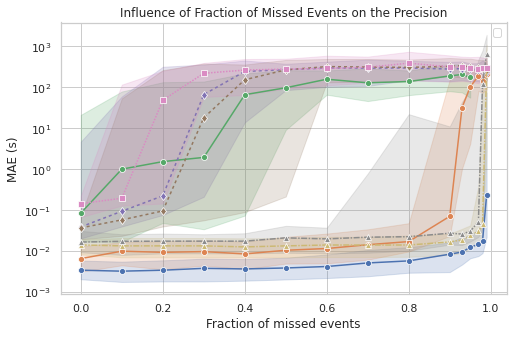

In [27]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_precision_retain_melted = pd.melt(df_precision_retain, id_vars="fraction", var_name="Method", 
                                     value_vars=METHODS, value_name="precision")
df_precision_retain_melted["fraction"] = 1.0 - df_precision_retain_melted["fraction"]
precision_retain_plot = sns.lineplot(data=df_precision_retain_melted, 
                              x="fraction", y="precision", 
                              hue="Method", style="Method", 
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS}, 
                              estimator=np.median, errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))
plt.title("Influence of Fraction of Missed Events on the Precision")
plt.xlabel("Fraction of missed events")
plt.ylabel("MAE (s)")
# plt.ylim((0.02, 50))
precision_retain_plot.set(yscale='log')
# precision_plot.set(xscale='log')
plt.savefig("fig/semisimulated_precision_retention.png")
plt.legend("")
plt.show()

## Experiment 2.c: Robustness against linear time-warping on Semi-Simulated data

In [28]:
TIME_WARP_SCALES = [0, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]  # we found 0.9934
METHODS = ['NAd-dense', 'NAd-sparse10', 'NAd-sparse100', 'PCC-FFT', 'PCC-FFT-smooth', 'KCC-0.5', 'KCC-1', 'DTW-asym']

# OFFSET = np.pi  # this is randomly sampled now
SUBSELECT_LENGTH = 1000
SIGMA = 0.1               # run with a relative sigma of 0.1
FRACTION = 1.0            # retain all events

In [29]:
# evaluate a given time_warp_scale
def evaluate_time_warp_scale(time_warp_scale):
    # generate semi-simulated pairs of measurements
    measurements = (heart_beat_dataset + breath_rate_dataset + step_rate_dataset)
    # measurements = (breath_rate_dataset)
    semi_simulated_pairs = list()
    n_measurements = 0
    for measurement in measurements:
        for array in measurement:
            offset = get_offset_array(array)
            semi_simulated_pairs.append(
                (array, modify_timeseries(arr=array, offset=offset, subselect_length=SUBSELECT_LENGTH, 
                                          sigma=SIGMA, fraction=FRACTION, time_warp_scale=time_warp_scale),
                offset)
            )
            n_measurements += 1
    assert n_measurements == 2 * len(measurements)  # otherwise there ar !=2 arrays per measurement
    
    # define the local DataFrame for one single pair
    df_precision = pd.DataFrame({m: np.nan*np.zeros(n_measurements) for m in METHODS})
    df_precision["time_warp_scale"] = [time_warp_scale for _ in range(n_measurements)]

    # loop through all semi-simulated pairs
    for idx, (arr_ref, arr_sig, offset) in enumerate(semi_simulated_pairs):
        # NAd-dense
        try:
            time_delays = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
            df_precision.loc[idx, "NAd-dense"] = np.abs(time_shift-offset)
        except:
            pass

        # NAd-sparse10
        try:
            time_delays = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=10, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
            df_precision.loc[idx, "NAd-sparse10"] = np.abs(time_shift-offset)
        except:
            pass

        # NAd-sparse100
        try:
            time_delays = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig, 
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=100, 
                dist_max=DIST_MAX, regulate_paddings=REGULATE_PADDINGS, dist_padding=DIST_MAX)
            time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
            df_precision.loc[idx, "NAd-sparse100"] = np.abs(time_shift-offset)
        except:
            pass
        
        # PCC-FFT
        try:
            time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, method="fft")
            df_precision.loc[idx, "PCC-FFT"] = np.abs(time_shift-offset)
        except AssertionError:
            pass
        
        # PCC-FFT-smooth
        try:
            time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, method="fft", smooth_outliers=True)
            df_precision.loc[idx, "PCC-FFT-smooth"] = np.abs(time_shift-offset)
        except AssertionError:
            pass
        
        # KCC-0.5
        try:
            time_shift, metric, time_delays =  kernel_cc(arr_ref, arr_sig, method="fft", kernel_width=0.5)
            df_precision.loc[idx, "KCC-0.5"] = np.abs(time_shift-offset)
        except AssertionError:
            pass
        # KCC-1
        try:
            time_shift, metric, time_delays =  kernel_cc(arr_ref, arr_sig, method="fft", kernel_width=1.0)
            df_precision.loc[idx, "KCC-1"] = np.abs(time_shift-offset)
        except AssertionError:
            pass

        # DTW-asym
        try:
            time_shift, alignment = dynamic_linear_timewarping(arr_ref, arr_sig)
            df_precision.loc[idx, "DTW-asym"] = np.abs(time_shift-offset)
        except AssertionError:
            pass
    return df_precision
   

# Initialize the pool with the number of processes
with Pool(processes=16) as pool: 
    results = pool.map(evaluate_time_warp_scale, TIME_WARP_SCALES)
df_precision_warp = pd.concat(results).sort_values("time_warp_scale")
df_precision_warp.head(5)

,NAd-dense,NAd-sparse10,NAd-sparse100,PCC-FFT,PCC-FFT-smooth,KCC-0.5,KCC-1,DTW-asym,time_warp_scale
0,0.002046,0.002046,0.007963,0.026021,0.026021,0.026021,0.026021,0.173979,0.0
69,1.052559,1.052406,1.042397,0.047447,0.047447,782.447447,779.997447,0.047447,0.0
68,0.001830,0.001830,0.028169,4.480724,0.019276,0.019276,720.430724,0.180724,0.0
67,0.005567,0.005567,0.035047,0.035041,0.035041,0.014959,0.014959,0.064959,0.0
66,0.002833,0.002833,53.257169,0.032167,0.032167,0.017833,0.017833,0.232167,0.0


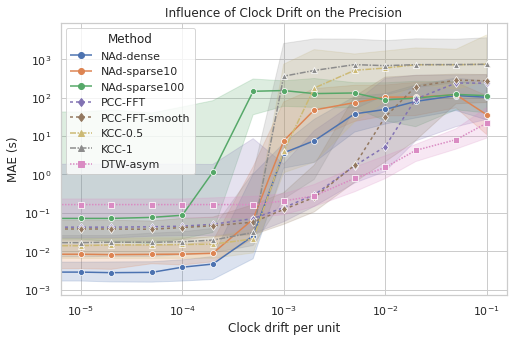

In [30]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_precision_warp_melted = pd.melt(df_precision_warp, id_vars="time_warp_scale", var_name="Method", 
                              value_vars=METHODS, value_name="precision")
precision_warp_plot = sns.lineplot(data=df_precision_warp_melted, 
                              x="time_warp_scale", y="precision", 
                              hue="Method", style="Method", 
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS}, 
                              estimator=np.median, errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))
plt.title("Influence of Clock Drift on the Precision")
plt.xlabel("Clock drift per unit")
plt.ylabel("MAE (s)")
# plt.ylim((0.02, 50))
precision_warp_plot.set(yscale='log')
precision_warp_plot.set(xscale='log')
plt.savefig("fig/semisimulated_precision_drift.png")
plt.show()

In [31]:
# what's the total event timestamp shift for the batch?
1e-3 * SUBSELECT_LENGTH / 2

0.5

### Plot all three experiments

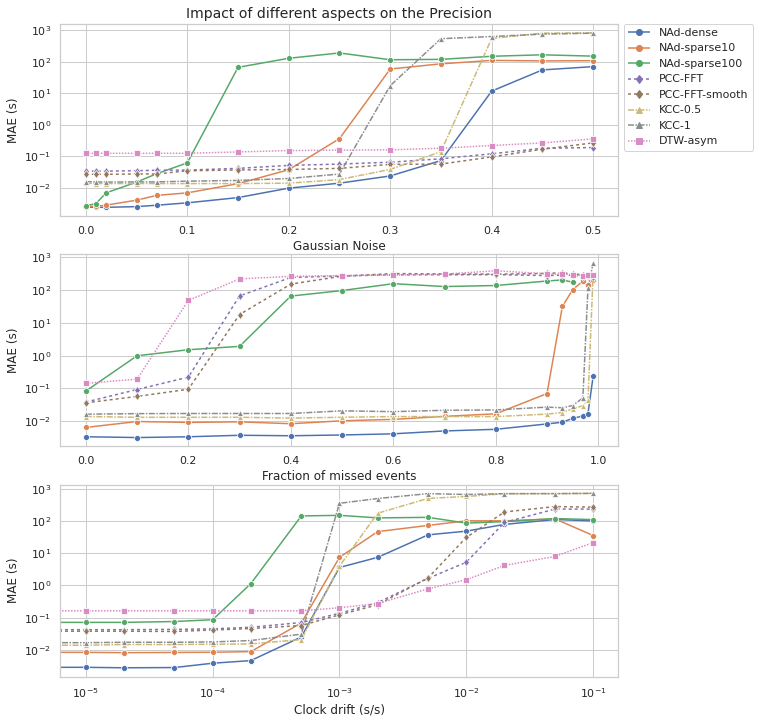

In [32]:
fig, axes = plt.subplots(3, 1, figsize=(10,12))
axes[0].set_title("Impact of different aspects on the Precision", size=14)

# Noise Plot
precision_noise_plot = sns.lineplot(data=df_precision_noise_melted, 
                              x="sigma", y="precision", 
                              hue="Method", style="Method", 
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS}, 
                              estimator=np.median, errorbar=None,
                              ax=axes[0])  # lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))
axes[0].set_xlabel("Gaussian Noise")
axes[0].set_ylabel("MAE (s)")
precision_noise_plot.set(yscale='log')

# Retain Plot
precision_retain_plot = sns.lineplot(data=df_precision_retain_melted, 
                              x="fraction", y="precision", 
                              hue="Method", style="Method", 
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS}, 
                              estimator=np.median, errorbar=None,
                              ax=axes[1])  # lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))
axes[1].set_xlabel("Fraction of missed events")
axes[1].set_ylabel("MAE (s)")
precision_retain_plot.set(yscale='log')

# Time warp Plot
precision_warp_plot = sns.lineplot(data=df_precision_warp_melted, 
                              x="time_warp_scale", y="precision", 
                              hue="Method", style="Method", 
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS}, 
                              estimator=np.median, errorbar=None,
                              ax=axes[2])  # lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))
axes[2].set_xlabel("Clock drift (s/s)")
axes[2].set_ylabel("MAE (s)")
precision_warp_plot.set(yscale='log')
precision_warp_plot.set(xscale='log')

axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].legend(loc=(1.01, 2.74))
plt.savefig("fig/semisimulated_precision.png")
# TODO: save manually to get the whole plot